In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [2]:
# Get current working directory
import os
cwd = os.getcwd()
print("Current working directory:", cwd)
os.chdir("n:/Incubator2025_ComputationalLifeCourse")

Current working directory: n:\Incubator2025_ComputationalLifeCourse\Scripts\g_comp


In [3]:
import sys
sys.path.append("Scripts/g_comp")  # relative path from your current working directory
import g_comp as gc

In [4]:
# Reload the module (if it's been edited and needs to be reloaded)
import importlib
importlib.reload(gc)

<module 'g_comp' from 'n:\\Incubator2025_ComputationalLifeCourse\\Scripts/g_comp\\g_comp.py'>

In [5]:
def set_seed(seed =42):
    """Set seed for reproducibility across multiple libraries"""
    random.seed(seed)  # Python's built-in random
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch
    torch.cuda.manual_seed_all(seed)  # PyTorch CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2025)  # Call this at the beginning of your code

In [6]:
## Load the data 
import pandas as pd
df = pd.read_csv("Data/Processed/g_data.csv")
df = df.sort_values(["mergeid", "t_age"]) 

In [7]:
## Check the number of dropped cases 
complete_y_self_rated_65_75_dic_mergeids = gc.summarize_mergeid_completeness(df, ["y_self_rated_65_75_dic", "dt_n_years_disease_dic"], "self_rated 65–75")

[self_rated 65–75]
Original mergeids: 20806
Complete mergeids (no missing values in Y): 14961
Number of unique mergeids dropped: 5845



In [8]:
###############
## Data prep ##
###############

# N = number of individuals, T = number of time points (i.e., 33)
# Generate datasets for pooled and by regime 
T = 33
df_self_rated_65_75 = gc.get_valid_df(df, complete_y_self_rated_65_75_dic_mergeids, "self_rated 65–75", T)
df_self_rated_med_65_75 = df_self_rated_65_75[df_self_rated_65_75["mod_welfare_regime_mediterranean"] == 1.0]
df_self_rated_cor_65_75 = df_self_rated_65_75[df_self_rated_65_75["mod_welfare_regime_corporatist"] == 1.0]
df_self_rated_scan_65_75 = df_self_rated_65_75[df_self_rated_65_75["mod_welfare_regime_scandinavian"] == 1.0]
 

# Mediterranean 
feature_cols_outcome_med_65_75 = gc.get_feature_cols(df_self_rated_med_65_75, context="outcome and med")
feature_cols_tv_covar_med_65_75 = gc.get_feature_cols(df_self_rated_med_65_75, context="tv_covar and med")

# Corporatist
feature_cols_outcome_cor_65_75 = gc.get_feature_cols(df_self_rated_cor_65_75, context="outcome and cor")
feature_cols_tv_covar_cor_65_75 = gc.get_feature_cols(df_self_rated_cor_65_75, context="tv_covar and cor")

# Scandinavian
feature_cols_outcome_scan_65_75 = gc.get_feature_cols(df_self_rated_scan_65_75, context="outcome and scan")
feature_cols_tv_covar_scan_65_75 = gc.get_feature_cols(df_self_rated_scan_65_75, context="tv_covar and scan")


# Convert to (N, T, D) tensor
# Treatment and covariates from the dataset 
 
# Mediterranean 
N_self_rated_med_65_75 = df_self_rated_med_65_75['mergeid'].nunique()
X_self_rated_med_65_75 = gc.convert_df_to_X(df_self_rated_med_65_75, feature_cols_outcome_med_65_75, N_self_rated_med_65_75, T)
X_disease_med_65_75  = gc.convert_df_to_X(df_self_rated_med_65_75, feature_cols_tv_covar_med_65_75, N_self_rated_med_65_75, T)

# Corporatist
N_self_rated_cor_65_75 = df_self_rated_cor_65_75['mergeid'].nunique()
X_self_rated_cor_65_75 = gc.convert_df_to_X(df_self_rated_cor_65_75, feature_cols_outcome_cor_65_75, N_self_rated_cor_65_75, T)
X_disease_cor_65_75  = gc.convert_df_to_X(df_self_rated_cor_65_75, feature_cols_tv_covar_cor_65_75, N_self_rated_cor_65_75, T)

# Scandinavian
N_self_rated_scan_65_75 = df_self_rated_scan_65_75['mergeid'].nunique()
X_self_rated_scan_65_75 = gc.convert_df_to_X(df_self_rated_scan_65_75, feature_cols_outcome_scan_65_75, N_self_rated_scan_65_75, T)
X_disease_scan_65_75  = gc.convert_df_to_X(df_self_rated_scan_65_75, feature_cols_tv_covar_scan_65_75, N_self_rated_scan_65_75, T)

[self_rated 65–75]
Mergeids with complete outcome and 33 unique ages: 14961
[get_feature_cols] Context: outcome and med | Exclude: ['mod_country_italy']
⚠️ dt_n_years_disease_dic IS STILL INCLUDED
[get_feature_cols] Context: tv_covar and med | Exclude: ['mod_country_italy', 'dt_n_years_disease_dic']
✅ dt_n_years_disease_dic successfully excluded
[get_feature_cols] Context: outcome and cor | Exclude: ['mod_country_germany']
⚠️ dt_n_years_disease_dic IS STILL INCLUDED
[get_feature_cols] Context: tv_covar and cor | Exclude: ['mod_country_germany', 'dt_n_years_disease_dic']
✅ dt_n_years_disease_dic successfully excluded
[get_feature_cols] Context: outcome and scan | Exclude: ['mod_country_sweden']
⚠️ dt_n_years_disease_dic IS STILL INCLUDED
[get_feature_cols] Context: tv_covar and scan | Exclude: ['mod_country_sweden', 'dt_n_years_disease_dic']
✅ dt_n_years_disease_dic successfully excluded


In [9]:
###############
## Y and L_t ##
###############

# Binary outcomes  
y_self_rated_med_65_75_dic = gc.extract_y_tensor(df_self_rated_med_65_75, "y_self_rated_65_75_dic")
y_self_rated_cor_65_75_dic = gc.extract_y_tensor(df_self_rated_cor_65_75, "y_self_rated_65_75_dic")
y_self_rated_scan_65_75_dic = gc.extract_y_tensor(df_self_rated_scan_65_75, "y_self_rated_65_75_dic")

# Binary outcomes for tv covar 
# Mediterranean 
y_self_rated_disease_med_65_75_dic = gc.extract_y_tensor(df_self_rated_med_65_75, "dt_n_years_disease_dic")
y_self_rated_disease_cor_65_75_dic = gc.extract_y_tensor(df_self_rated_cor_65_75, "dt_n_years_disease_dic")
y_self_rated_disease_scan_65_75_dic = gc.extract_y_tensor(df_self_rated_scan_65_75, "dt_n_years_disease_dic")

In [10]:
#####################
## \vec{a} and L_0 ##
#####################

# Extract high-level treatment trajectory features with covariates for each X matrix
# Mediterranean
X_med_features_self_rated_65_75_dic = gc.extract_features(X_self_rated_med_65_75, feature_cols_outcome_med_65_75)
X_med_features_disease_65_75_dic  = gc.extract_features(X_disease_med_65_75, feature_cols_tv_covar_med_65_75)

# Corporatist
X_cor_features_self_rated_65_75_dic = gc.extract_features(X_self_rated_cor_65_75, feature_cols_outcome_cor_65_75)
X_cor_features_disease_65_75_dic  = gc.extract_features(X_disease_cor_65_75, feature_cols_tv_covar_cor_65_75)

# Scandinavian
X_scan_features_self_rated_65_75_dic = gc.extract_features(X_self_rated_scan_65_75, feature_cols_outcome_scan_65_75)
X_scan_features_disease_65_75_dic  = gc.extract_features(X_disease_scan_65_75, feature_cols_tv_covar_scan_65_75)



# Feature Names
trt_features_med_self_rated_65_75_dic   = gc.create_feature_df(X_med_features_self_rated_65_75_dic, feature_cols_outcome_med_65_75, "self_rated 65–75")
trt_features_cor_self_rated_65_75_dic   = gc.create_feature_df(X_cor_features_self_rated_65_75_dic, feature_cols_outcome_cor_65_75, "self_rated 65–75")
trt_features_scan_self_rated_65_75_dic   = gc.create_feature_df(X_scan_features_self_rated_65_75_dic, feature_cols_outcome_scan_65_75, "self_rated 65–75")


self_rated 65–75: Feature dataframe shape = (4706, 48)
self_rated 65–75: Feature dataframe shape = (7382, 48)
self_rated 65–75: Feature dataframe shape = (2873, 48)


In [11]:
################### 
## Linear models ##
#################### 

y_self_rated_med_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_med_features_self_rated_65_75_dic, y_self_rated_med_65_75_dic, "self_rated 65–75 (med, logistic)", save_dir="model_outputs/self_rated/med")
y_disease_med_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_med_features_disease_65_75_dic, y_self_rated_disease_med_65_75_dic, "disease 65–75 (med, logistic)", save_dir="model_outputs/self_rated/med")

y_self_rated_cor_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_cor_features_self_rated_65_75_dic, y_self_rated_cor_65_75_dic, "self_rated 65–75 (cor, logistic)", save_dir="model_outputs/self_rated/cor")
y_disease_cor_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_cor_features_disease_65_75_dic, y_self_rated_disease_cor_65_75_dic, "disease 65–75 (cor, logistic)", save_dir="model_outputs/self_rated/cor")

y_self_rated_scan_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_scan_features_self_rated_65_75_dic, y_self_rated_scan_65_75_dic, "self_rated 65–75 (scan, logistic)", save_dir="model_outputs/self_rated/scan")
y_disease_scan_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_scan_features_disease_65_75_dic, y_self_rated_disease_scan_65_75_dic, "disease 65–75 (scan, logistic)", save_dir="model_outputs/self_rated/scan")


=== self_rated 65–75 (med, logistic) ===
Train Accuracy: 0.652701882210079
Test Accuracy: 0.6720963172804533
Test AUC: 0.7344271980995971

=== disease 65–75 (med, logistic) ===
Train Accuracy: 0.5956284153005464
Test Accuracy: 0.5814447592067988
Test AUC: 0.572253081585194

=== self_rated 65–75 (cor, logistic) ===
Train Accuracy: 0.6576349912908844
Test Accuracy: 0.6541760722347629
Test AUC: 0.6965749288966407

=== disease 65–75 (cor, logistic) ===
Train Accuracy: 0.6195084188116896
Test Accuracy: 0.5972911963882619
Test AUC: 0.5926186895923706

=== self_rated 65–75 (scan, logistic) ===
Train Accuracy: 0.6877175534559921
Test Accuracy: 0.6450116009280742
Test AUC: 0.6903233292079208

=== disease 65–75 (scan, logistic) ===
Train Accuracy: 0.65191447041273
Test Accuracy: 0.6589327146171694
Test AUC: 0.6797334416589292


In [12]:
# Logistic regression coefficients 
y_self_rated_med_65_75_logistic_coef_summary = gc.logistic_coef_summary(
    y_self_rated_med_65_75_dic_logistic,
    trt_features_med_self_rated_65_75_dic,
    y_self_rated_med_65_75_dic,
    label="y_self_rated_med_65_75_dic_logistic",   # this will be used for the file name
    save_dir="model_outputs/self_rated/med"
)

y_self_rated_cor_65_75_logistic_coef_summary = gc.logistic_coef_summary(
    y_self_rated_cor_65_75_dic_logistic,
    trt_features_cor_self_rated_65_75_dic,
    y_self_rated_med_65_75_dic,
    label="y_self_rated_cor_65_75_dic_logistic",   # this will be used for the file name
    save_dir="model_outputs/self_rated/cor"
)

y_self_rated_scan_65_75_logistic_coef_summary = gc.logistic_coef_summary(
    y_self_rated_scan_65_75_dic_logistic,
    trt_features_scan_self_rated_65_75_dic,
    y_self_rated_scan_65_75_dic,
    label="y_self_rated_scan_65_75_dic_logistic",   # this will be used for the file name
    save_dir="model_outputs/self_rated/scan"
)

print(y_self_rated_med_65_75_logistic_coef_summary)
print(y_self_rated_cor_65_75_logistic_coef_summary)
print(y_self_rated_scan_65_75_logistic_coef_summary)

c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
n:\Incubator2025_ComputationalLifeCourse\Scripts/g_comp\g_comp.py:542: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov_logit))
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
n:\Incubator2025_ComputationalLifeCourse\Scripts/g_comp\g_comp.py:542: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov_logit))


✅ Saved coefficient summary to: model_outputs/self_rated/med\y_self_rated_med_65_75_dic_logistic_coef_summary.csv
✅ Saved coefficient summary to: model_outputs/self_rated/cor\y_self_rated_cor_65_75_dic_logistic_coef_summary.csv
✅ Saved coefficient summary to: model_outputs/self_rated/scan\y_self_rated_scan_65_75_dic_logistic_coef_summary.csv
                      feature      coef  odds_ratio     std_error  \
0                   Intercept  0.040623    1.041459           NaN   
1               cum_full_time  0.089032    1.093115  1.364719e-01   
2               cum_part_time  0.121344    1.129014  9.322018e-02   
3                 years_cohab -0.007609    0.992420           NaN   
4             years_not_cohab  0.007609    1.007638           NaN   
5         years_with_children  0.230458    1.259177  3.803483e+07   
6      years_without_children -0.230458    0.794169  3.786869e+07   
7     dominant_work_full_time -0.032393    0.968126           NaN   
8     dominant_work_part_time -0.01

c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
n:\Incubator2025_ComputationalLifeCourse\Scripts/g_comp\g_comp.py:542: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov_logit))


In [13]:
############################
## Tuning for best models ##
############################
# Best models for med sample 
y_self_rated_med_65_75_dic_model, y_self_rated_med_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_med_features_self_rated_65_75_dic, y_self_rated_med_65_75_dic, "self_rated 65–75 (med)", save_dir="model_outputs/self_rated/med")
y_self_rated_disease_med_65_75_dic_model, y_self_rated_disease_med_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_med_features_disease_65_75_dic, y_self_rated_disease_med_65_75_dic, "self_rated disease 65–75 (med)", save_dir="model_outputs/self_rated/med")

c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:51:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:51:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:51:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:51:51] WARNING: C:\actions-r


=== self_rated 65–75 (med) ===
Train Accuracy: 0.7264723740133576
Test Accuracy: 0.669971671388102
Test AUC: 0.7408151578981446


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:52:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:1


=== self_rated disease 65–75 (med) ===
Train Accuracy: 0.6092896174863388
Test Accuracy: 0.5864022662889519
Test AUC: 0.5775336474160472


In [14]:
# Best models for cor sample 
y_self_rated_cor_65_75_dic_model, y_self_rated_cor_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_cor_features_self_rated_65_75_dic, y_self_rated_cor_65_75_dic, "self_rated 65–75 (cor)", save_dir="model_outputs/self_rated/cor")
y_self_rated_disease_cor_65_75_dic_model, y_self_rated_disease_cor_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_cor_features_disease_65_75_dic, y_self_rated_disease_cor_65_75_dic, "self_rated disease 65–75 (cor)", save_dir="model_outputs/self_rated/cor")

c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:53:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:53:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:53:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:53:36] WARNING: C:\actions-r


=== self_rated 65–75 (cor) ===
Train Accuracy: 0.684730017418231
Test Accuracy: 0.6568848758465011
Test AUC: 0.7008621545116784


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:54:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:54:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:54:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:54:31] WARNING: C:\actions-r


=== self_rated disease 65–75 (cor) ===
Train Accuracy: 0.6545384168763305
Test Accuracy: 0.599097065462754
Test AUC: 0.5979525372844483


In [15]:
# Best models for scan sample 
y_self_rated_scan_65_75_dic_model, y_self_rated_scan_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_scan_features_self_rated_65_75_dic, y_self_rated_scan_65_75_dic, "self_rated 65–75 (scan)", save_dir="model_outputs/self_rated/scan")
y_self_rated_disease_scan_65_75_dic_model, y_self_rated_disease_scan_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_scan_features_disease_65_75_dic, y_self_rated_disease_scan_65_75_dic, "self_rated disease 65–75 (scan)", save_dir="model_outputs/self_rated/scan")

c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:55:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:55:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:55:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:55:05] WARNING: C:\actions-r


=== self_rated 65–75 (scan) ===
Train Accuracy: 0.747886623570363
Test Accuracy: 0.6577726218097448
Test AUC: 0.7000438325082509


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_


=== self_rated disease 65–75 (scan) ===
Train Accuracy: 0.8741919443063153
Test Accuracy: 0.642691415313225
Test AUC: 0.6725955586505725


In [16]:
#############################
## Counterfactual analysis ## 
#############################

import pandas as pd
# Load CSV
medoid_df = pd.read_csv("Data/Processed/medoid_seq_data.csv")

# Sort by cluster and t_age
medoid_df = medoid_df.sort_values(["cluster", "t_age"])

# Reorder columns so cluster is first
cols = ["cluster"] + [col for col in medoid_df.columns if col != "cluster"]
medoid_df = medoid_df[cols]

N_medoid = medoid_df['cluster'].nunique()
X_medoid_self_rated_65_75_dic   = gc.convert_df_to_X(medoid_df, feature_cols_outcome_med_65_75, N_medoid, T)
X_medoid_disease_65_75_dic  = gc.convert_df_to_X(medoid_df, feature_cols_tv_covar_med_65_75, N_medoid, T)
X_medoid_features_65_75_dic   = gc.extract_treatment_features_from_medoid(X_medoid_self_rated_65_75_dic, feature_cols_outcome_med_65_75) 

In [17]:
################################################# 
## refit the final model with all origina data ##
#################################################
 
 
# Mediterranean models
y_self_rated_med_final_models = gc.refit_and_save_final_models(
    X=X_med_features_self_rated_65_75_dic,
    y=y_self_rated_med_65_75_dic,
    base_models=y_self_rated_med_65_75_dic_best_models,
    label="self_rated 65–75 (med)",
    save=False
)

y_self_rated_disease_med_final_models = gc.refit_and_save_final_models(
    X=X_med_features_disease_65_75_dic,
    y=y_self_rated_disease_med_65_75_dic,
    base_models=y_self_rated_disease_med_65_75_dic_best_models,
    label="disease 65–75 (med)",
    save=False
)

y_self_rated_med_super_learner = gc.refit_and_save_super_learner(
    X=X_med_features_self_rated_65_75_dic,
    y=y_self_rated_med_65_75_dic,
    base_models=y_self_rated_med_final_models,
    label="self_rated 65–75 (med)",
    save=True
)

y_self_rated_disease_med_super_learner = gc.refit_and_save_super_learner(
    X=X_med_features_disease_65_75_dic,
    y=y_self_rated_disease_med_65_75_dic,
    base_models=y_self_rated_disease_med_final_models,
    label="self_rated disease 65–75 (med)",
    save=True
)


# Corporatist models
y_self_rated_cor_final_models = gc.refit_and_save_final_models(
    X=X_cor_features_self_rated_65_75_dic,
    y=y_self_rated_cor_65_75_dic,
    base_models=y_self_rated_cor_65_75_dic_best_models,
    label="self_rated 65–75 (cor)",
    save=False
)

y_self_rated_disease_cor_final_models = gc.refit_and_save_final_models(
    X=X_cor_features_disease_65_75_dic,
    y=y_self_rated_disease_cor_65_75_dic,
    base_models= y_self_rated_disease_cor_65_75_dic_best_models,
    label="self_rated disease 65–75 (cor)",
    save=False
)

y_self_rated_cor_super_learner = gc.refit_and_save_super_learner(
    X=X_cor_features_self_rated_65_75_dic,
    y=y_self_rated_cor_65_75_dic,
    base_models=y_self_rated_cor_final_models,
    label="self_rated 65–75 (cor)",
    save=True
)

y_self_rated_disease_cor_super_learner = gc.refit_and_save_super_learner(
    X=X_cor_features_disease_65_75_dic,
    y=y_self_rated_disease_cor_65_75_dic,
    base_models=y_self_rated_disease_cor_final_models,
    label="self_rated disease 65–75 (cor)",
    save=True
)


# Scandinavian models
y_self_rated_scan_final_models = gc.refit_and_save_final_models(
    X=X_scan_features_self_rated_65_75_dic,
    y=y_self_rated_scan_65_75_dic,
    base_models=y_self_rated_scan_65_75_dic_best_models,
    label="self_rated 65–75 (scan)",
    save=False
)

y_self_rated_disease_scan_final_models = gc.refit_and_save_final_models(
    X=X_scan_features_disease_65_75_dic,
    y=y_self_rated_disease_scan_65_75_dic,
    base_models=y_self_rated_disease_scan_65_75_dic_best_models,
    label="self_rated disease 65–75 (scan)",
    save=False
)

y_self_rated_scan_super_learner = gc.refit_and_save_super_learner(
    X=X_scan_features_self_rated_65_75_dic,
    y=y_self_rated_scan_65_75_dic,
    base_models=y_self_rated_scan_final_models,
    label="self_rated 65–75 (scan)",
    save=True
)

y_self_rated_disease_scan_super_learner = gc.refit_and_save_super_learner(
    X=X_scan_features_disease_65_75_dic,
    y=y_self_rated_disease_scan_65_75_dic,
    base_models=y_self_rated_disease_scan_final_models,
    label="self_rated disease 65–75 (scan)",
    save=True
)



🔁 Refitting LASSO on full data...

🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



🔁 Refitting XGB on full data...

🔁 Refitting LASSO on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:55:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



🔁 Refitting XGB on full data...

🔁 Fitting SUPER LEARNER for self_rated 65–75 (med)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:56:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:

✅ Saved SUPER LEARNER to: intermediate\self_rated_65-75_(med)_super_learner.pkl

🔁 Fitting SUPER LEARNER for self_rated disease 65–75 (med)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:56:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:

✅ Saved SUPER LEARNER to: intermediate\self_rated_disease_65-75_(med)_super_learner.pkl

🔁 Refitting LASSO on full data...

🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



🔁 Refitting XGB on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:56:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



🔁 Refitting LASSO on full data...

🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



🔁 Refitting XGB on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:56:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



🔁 Fitting SUPER LEARNER for self_rated 65–75 (cor)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:56:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:56:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:56:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:56:18] WARNING: C:\actions-r

✅ Saved SUPER LEARNER to: intermediate\self_rated_65-75_(cor)_super_learner.pkl

🔁 Fitting SUPER LEARNER for self_rated disease 65–75 (cor)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:56:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:

✅ Saved SUPER LEARNER to: intermediate\self_rated_disease_65-75_(cor)_super_learner.pkl

🔁 Refitting LASSO on full data...

🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



🔁 Refitting XGB on full data...

🔁 Refitting LASSO on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:56:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



🔁 Refitting XGB on full data...

🔁 Fitting SUPER LEARNER for self_rated 65–75 (scan)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:56:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:

✅ Saved SUPER LEARNER to: intermediate\self_rated_65-75_(scan)_super_learner.pkl

🔁 Fitting SUPER LEARNER for self_rated disease 65–75 (scan)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:56:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model

✅ Saved SUPER LEARNER to: intermediate\self_rated_disease_65-75_(scan)_super_learner.pkl



=== Permutation Importance (Super Learner) ===
                   feature  importance_mean  importance_std
4      years_with_children         0.257500        0.002400
2              years_cohab         0.242793        0.005601
3          years_not_cohab         0.190520        0.005864
5   years_without_children         0.186092        0.002285
44           pre_edu_years         0.065333        0.002000
30  dt_n_years_disease_dic         0.052174        0.005477
33    pre_selfrated_health         0.038514        0.002106
31             pre_yrbirth         0.026934        0.001898
13   dominant_c_with_child         0.006762        0.001138
41         pre_total_accom         0.006589        0.001567
39             pre_room_pp         0.005031        0.000709
32     pre_ch_n_child_cond         0.003876        0.000593
23   last_work_not_working         0.003588        0.000741
19     longest_cohab_spell         0.003268        0.000670
16          first_fulltime         0.002880        0

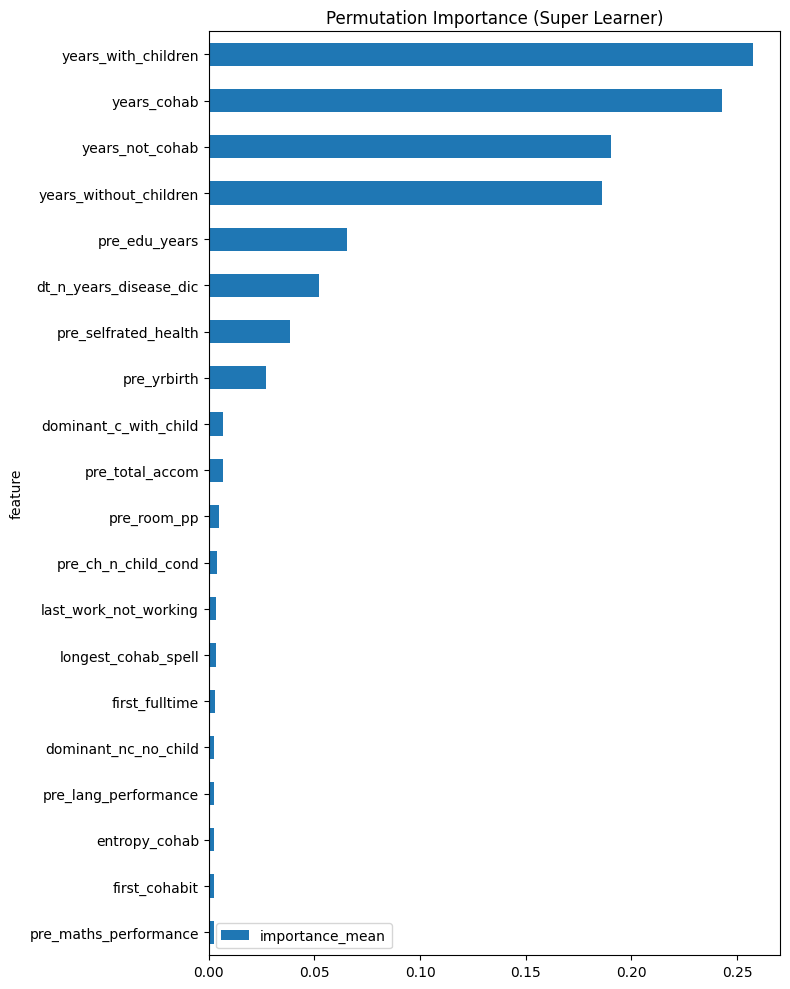

In [18]:
gc.plot_super_learner_permutation_importance(X = X_med_features_self_rated_65_75_dic, 
                                             y = y_self_rated_med_65_75_dic, 
                                             model = y_self_rated_med_super_learner, 
                                             feature_names = trt_features_med_self_rated_65_75_dic.columns.tolist(), 
                                             label = "self_rated 65-75 (med)", output_dir="model_outputs/self_rated/med")


=== Permutation Importance (Super Learner) ===
                    feature  importance_mean  importance_std
4       years_with_children         0.218230        0.005655
2               years_cohab         0.189341        0.005760
3           years_not_cohab         0.172448        0.005263
5    years_without_children         0.155928        0.005434
30   dt_n_years_disease_dic         0.058574        0.006168
33     pre_selfrated_health         0.042960        0.003180
41          pre_total_accom         0.011620        0.001621
27  last_cohab_c_with_child         0.007343        0.001547
37                pre_rooms         0.007215        0.000999
40              pre_n_books         0.007111        0.001451
31              pre_yrbirth         0.006784        0.000743
13    dominant_c_with_child         0.006213        0.001329
44            pre_edu_years         0.004554        0.000895
39              pre_room_pp         0.004293        0.000325
0             cum_full_time         0

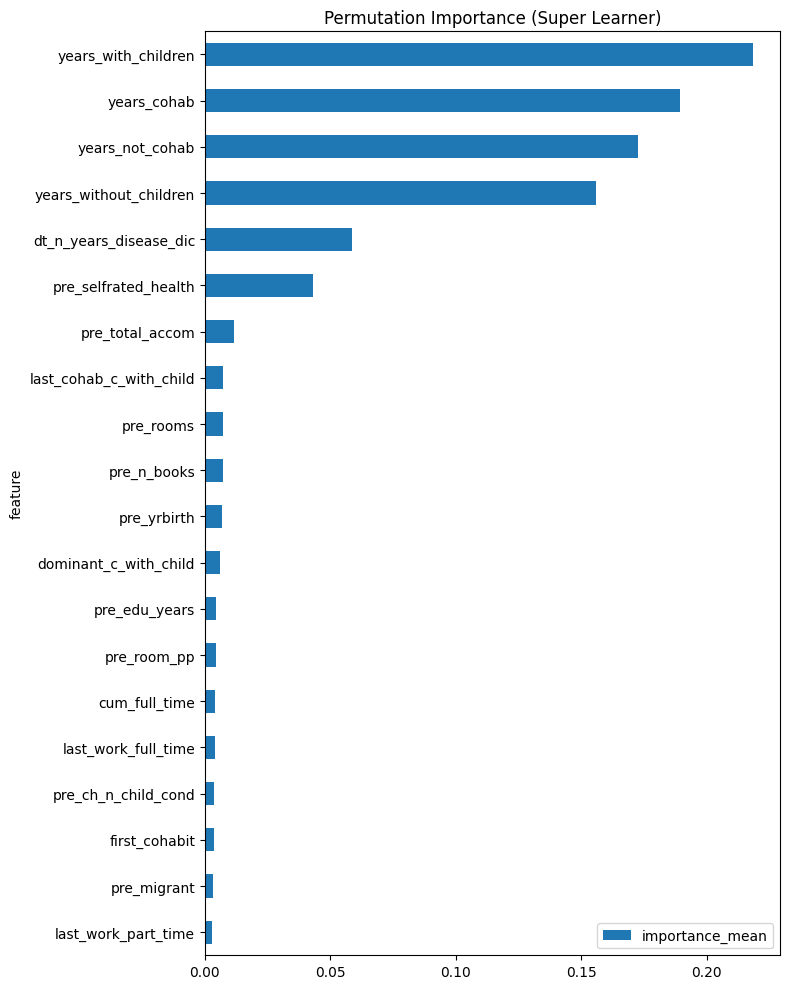

In [19]:
gc.plot_super_learner_permutation_importance(X = X_cor_features_self_rated_65_75_dic, 
                                             y = y_self_rated_cor_65_75_dic, 
                                             model = y_self_rated_cor_super_learner, 
                                             feature_names = trt_features_cor_self_rated_65_75_dic.columns.tolist(), 
                                             label = "self_rated 65-75 (cor)", output_dir="model_outputs/self_rated/cor")


=== Permutation Importance (Super Learner) ===
                   feature  importance_mean  importance_std
5   years_without_children         0.049261        0.002547
33    pre_selfrated_health         0.039937        0.003626
30  dt_n_years_disease_dic         0.032192        0.002012
2              years_cohab         0.030323        0.002138
0            cum_full_time         0.026049        0.004868
44           pre_edu_years         0.023137        0.001852
20     last_work_full_time         0.016082        0.002579
23   last_work_not_working         0.013709        0.001662
3          years_not_cohab         0.012800        0.001569
4      years_with_children         0.012771        0.000222
37               pre_rooms         0.009289        0.001949
38           pre_people_hh         0.005314        0.001866
29           entropy_cohab         0.005298        0.000381
39             pre_room_pp         0.004591        0.000276
19     longest_cohab_spell         0.004517        0

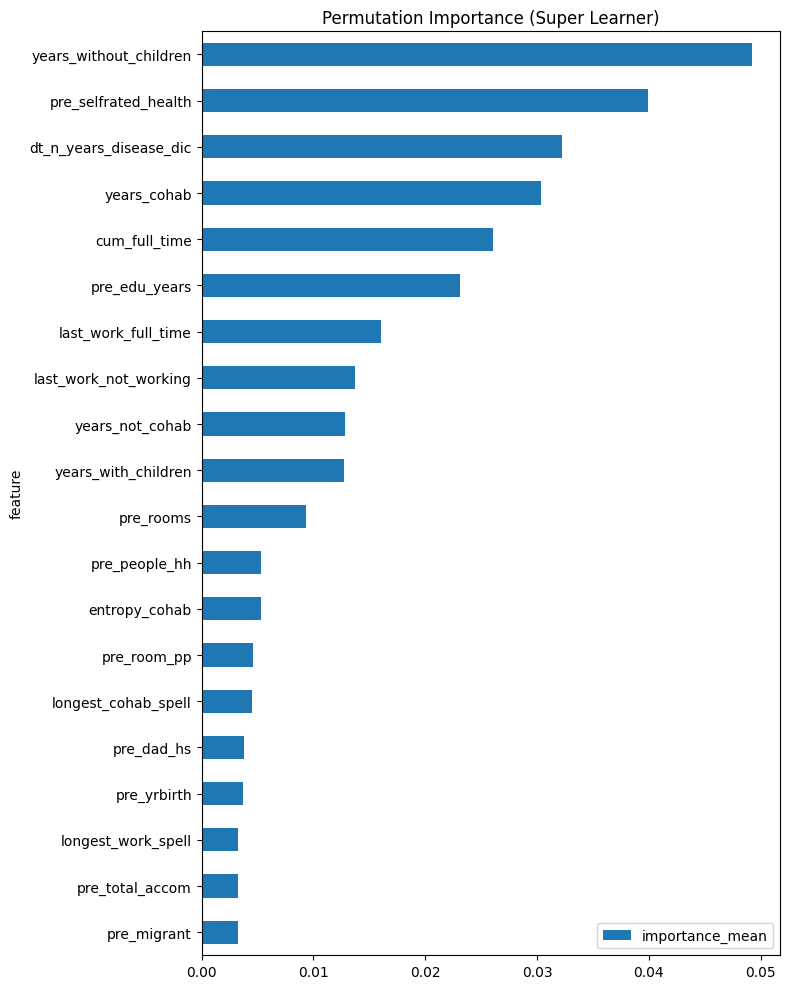

In [20]:
gc.plot_super_learner_permutation_importance(X = X_scan_features_self_rated_65_75_dic, 
                                             y = y_self_rated_scan_65_75_dic, 
                                             model = y_self_rated_scan_super_learner, 
                                             feature_names = trt_features_scan_self_rated_65_75_dic.columns.tolist(), 
                                             label = "self_rated 65-75 (scan)", output_dir="model_outputs/self_rated/scan")